In [1]:
# パッケージのimport
import glob
import cv2
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [4]:
# 学習、検証の画像データのファイルパスリストを作成する


def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list,  val_img_list
        データへのパスを格納したリスト
    """

    # 画像ファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 訓練データの画像ファイルのパスリストを作成
    train_img_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        train_img_list.append(img_path)  # リストに追加

    # 検証データの画像ファイルへのパスリストを作成
    val_img_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        val_img_list.append(img_path)  # リストに追加

    return train_img_list,val_img_list


In [5]:
# ファイルパスのリストを作成
rootpath = "./data2/"
train_img_list,  val_img_list= make_datapath_list(
    rootpath)

# 動作確認
print(train_img_list[0])
print(val_img_list[0])

./data2/JPEGImages\2008_000008.jpg
./data2/JPEGImages\2008_000002.jpg


In [6]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, Resize, SubtractMeans


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


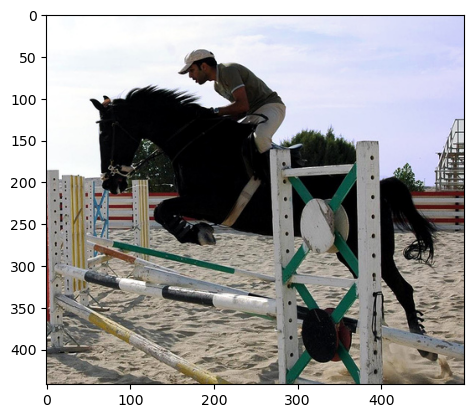

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


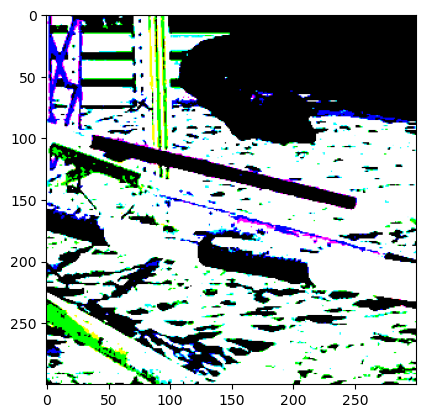

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


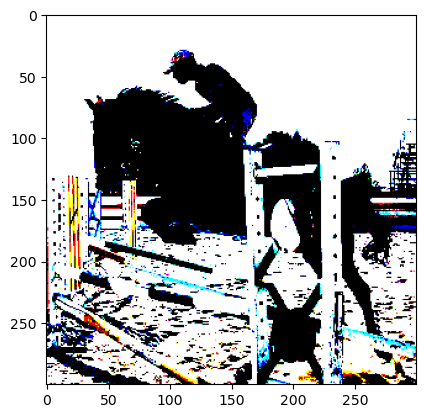

In [7]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed = transform(
    img, phase)
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed = transform(
    img, phase)
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
#Datasetを作成する


class MyDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, img_list,phase, transform):
        self.file_list = img_list  # ファイルパスのリスト
        self.phase = phase
        self.transform = transform  # 前処理クラスのインスタンス

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        return img_transformed

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''
        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得


        # 3. 前処理を実施
        img = self.transform(
            img, self.phase)

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
        
        return img,height, width

In [9]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = MyDataset(train_img_list, phase="train", transform=DataTransform(
    input_size, color_mean))

val_dataset = MyDataset(val_img_list, phase="val", transform=DataTransform(
    input_size, color_mean))


# データの取り出し例
val_dataset.__getitem__(1)


array([[[  19.941666  ,   25.941666  ,   26.274994  ],
        [  25.164993  ,   30.164993  ,   36.164993  ],
        [  30.128326  ,   35.128326  ,   43.128326  ],
        ...,
        [  -3.9083328 ,  -18.076668  ,   -6.1500015 ],
        [   5.779999  ,  -14.724998  ,    3.0550003 ],
        [   9.596664  ,  -11.8533325 ,    8.816666  ]],

       [[  25.436676  ,   31.436676  ,   31.880005  ],
        [  28.660004  ,   33.660004  ,   39.33      ],
        [  32.828323  ,   37.828323  ,   45.49832   ],
        ...,
        [  -2.4433365 ,  -13.501663  ,   -3.165001  ],
        [   0.34999847,  -10.824997  ,    2.5149994 ],
        [   0.7966614 ,  -10.378334  ,    3.796669  ]],

       [[  29.883331  ,   35.791656  ,   37.066666  ],
        [  32.550003  ,   37.550003  ,   41.550003  ],
        [  35.699997  ,   40.699997  ,   46.149994  ],
        ...,
        [  -1.9916687 ,  -11.841667  ,   -3.3583298 ],
        [  -5.5250015 ,  -13.074997  ,   -4.175003  ],
        [  -6.1916656 

In [14]:
# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])

torch.Size([4, 300, 300, 3])
